# Deribit inverse option calibration example (price-based)

This notebook demonstrates:
1. Loading a Deribit options snapshot CSV  
2. Filtering to keep liquid quotes (requires **both bid and ask**)  
3. Splitting into train/test  
4. Calibrating **Black**, **Heston**, and **SVCJ** (price-based, weighted)  
5. Repricing train/test and plotting **true vs model** prices (coin units)

> Notes  
> - We calibrate to **coin-denominated** mid prices (Deribit convention).  
> - The forward/underlying used is the **term future mark** (per-expiry median `futures_price`).  


In [3]:
import os, sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make sure we can import the local modules (assumes this notebook lives next to the .py files)
sys.path.append(str(Path().resolve()))

from src.calibration import (
    filter_liquid_options,
    calibrate_model,
    price_dataframe,
    WeightConfig,
)
from src.inverse_fft_pricer import FFTParams


In [4]:
# --- Load snapshot ---
# Put the CSV next to this notebook (or edit the path here).
CSV_PATH = str(Path("data/deribit_options_snapshot_20251230T173115Z.csv").resolve())

raw = pd.read_csv(CSV_PATH)
raw.shape, raw.columns.tolist()[:8]


((1304, 23),
 ['timestamp',
  'instrument_name',
  'underlying',
  'underlying_name',
  'option_type',
  'strike',
  'expiry_datetime',
  'time_to_maturity'])

In [5]:
# --- Filter to liquid options (BTC example) ---
# Per your request: rows without bid OR ask are removed.
df = filter_liquid_options(
    raw,
    currency="BTC",
    require_bid_ask=True,
    min_time_to_maturity=1/365,     # >= 1 day
    min_open_interest=1,
    min_vega=0.0,
    max_rel_spread=0.5,             # drop very wide markets
    moneyness_range=(0.6, 1.4),     # focus on relatively liquid region
    drop_synthetic_underlyings=False
)

df.shape

(328, 29)

In [6]:
# Show a glimpse of the cleaned dataset
df.head(10)

,timestamp,instrument_name,underlying,underlying_name,option_type,strike,expiry_datetime,time_to_maturity,bid_price,ask_price,...,bid_ask_spread,currency,index_price,volume_usd,mid_price_clean,spread,rel_spread,F0,moneyness,log_moneyness
0,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-82000-P,88551.133465,SYN.BTC-1JAN26,put,82000.0,2026-01-01T08:00:00+00:00,0.00439,0.0002,0.0003,...,0.0001,BTC,88520.75,900.52,0.00025,0.0001,0.400000,88551.133465,0.926019,-0.076861
1,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-84000-P,88551.133465,SYN.BTC-1JAN26,put,84000.0,2026-01-01T08:00:00+00:00,0.00439,0.0005,0.0007,...,0.0002,BTC,88527.34,1490.36,0.00060,0.0002,0.333333,88551.133465,0.948604,-0.052763
2,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-85000-P,88551.133465,SYN.BTC-1JAN26,put,85000.0,2026-01-01T08:00:00+00:00,0.00439,0.0009,0.0012,...,0.0003,BTC,88524.21,705.19,0.00105,0.0003,0.285714,88551.133465,0.959897,-0.040929
3,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-86000-C,88551.133465,SYN.BTC-1JAN26,call,86000.0,2026-01-01T08:00:00+00:00,0.00439,0.0290,0.0320,...,0.0030,BTC,88543.09,5386.67,0.03050,0.0030,0.098361,88551.133465,0.971190,-0.029233
4,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-86000-P,88551.133465,SYN.BTC-1JAN26,put,86000.0,2026-01-01T08:00:00+00:00,0.00439,0.0017,0.0020,...,0.0003,BTC,88519.39,1499.63,0.00185,0.0003,0.162162,88551.133465,0.971190,-0.029233
5,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-87000-C,88551.133465,SYN.BTC-1JAN26,call,87000.0,2026-01-01T08:00:00+00:00,0.00439,0.0200,0.0225,...,0.0025,BTC,88521.33,35170.59,0.02125,0.0025,0.117647,88551.133465,0.982483,-0.017672
6,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-87000-P,88551.133465,SYN.BTC-1JAN26,put,87000.0,2026-01-01T08:00:00+00:00,0.00439,0.0034,0.0038,...,0.0004,BTC,88549.42,30083.21,0.00360,0.0004,0.111111,88551.133465,0.982483,-0.017672
7,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-88000-C,88553.779553,SYN.BTC-1JAN26,call,88000.0,2026-01-01T08:00:00+00:00,0.00439,0.0125,0.0135,...,0.0010,BTC,88521.19,47154.29,0.01300,0.0010,0.076923,88551.133465,0.993776,-0.006243
8,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-88000-P,88551.133465,SYN.BTC-1JAN26,put,88000.0,2026-01-01T08:00:00+00:00,0.00439,0.0065,0.0070,...,0.0005,BTC,88519.48,16073.33,0.00675,0.0005,0.074074,88551.133465,0.993776,-0.006243
9,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-89000-C,88551.133465,SYN.BTC-1JAN26,call,89000.0,2026-01-01T08:00:00+00:00,0.00439,0.0070,0.0075,...,0.0005,BTC,88519.99,20111.32,0.00725,0.0005,0.068966,88551.133465,1.005069,0.005056


In [7]:
# --- Train/test split (random) ---
rng = np.random.default_rng(42)
mask = rng.random(len(df)) < 0.70
train = df[mask].reset_index(drop=True)
test  = df[~mask].reset_index(drop=True)

train.shape, test.shape

((235, 29), (93, 29))

In [8]:
# --- Weighting scheme ---
# Default: divide by spread, and upweight sqrt(vega) and sqrt(open_interest)
wcfg = WeightConfig(
    use_spread=True,
    use_vega=True,
    use_open_interest=True,
    spread_power=1.0,
    vega_power=0.5,
    oi_power=0.5,
    cap=1e6,
)

# --- FFT configuration ---
# Keep this modest for calibration speed in an example notebook.
fft_base = FFTParams(N=2**11, alpha=1.5, eta=0.15, b=-5.0, use_simpson=True)


In [9]:
# --- Calibrate models on TRAIN set ---

black_fit = calibrate_model(
    train, "black",
    weight_config=wcfg,
    fft_params_base=fft_base,
    dynamic_b=True,
    max_nfev=30,
    verbose=0,
)

heston_fit = calibrate_model(
    train, "heston",
    weight_config=wcfg,
    fft_params_base=fft_base,
    dynamic_b=True,
    max_nfev=50,
    verbose=0,
)

svcj_fit = calibrate_model(
    train, "svcj",
    weight_config=wcfg,
    fft_params_base=fft_base,
    dynamic_b=True,
    max_nfev=40,
    verbose=0,
)

black_fit, heston_fit, svcj_fit

(CalibrationResult(model='black', params={'sigma': 0.4355468747462648}, success=True, message='`ftol` termination condition is satisfied.', nfev=4, rmse=0.005502006370498492, mae=0.003702131980518387),
 CalibrationResult(model='heston', params={'kappa': 6.0574079253867685, 'theta': 0.2781094201587534, 'sigma_v': 2.5259681314892157, 'rho': -0.2352981221418304, 'v0': 0.15312901365101897}, success=True, message='`ftol` termination condition is satisfied.', nfev=10, rmse=0.0017956553976523355, mae=0.0006656771228403922),
 CalibrationResult(model='svcj', params={'kappa': 2.6019388737602394, 'theta': 0.1877264957604281, 'sigma_v': 1.0609445798429824, 'rho': -0.14276830018314274, 'v0': 0.12209565532175648, 'lam': 0.7823843448447578, 'ell_y': -0.198989366034755, 'sigma_y': 0.23637890519122423, 'ell_v': 0.18917166065907332, 'rho_j': 0.31955186549796877}, success=False, message='The maximum number of function evaluations is exceeded.', nfev=40, rmse=0.001735450643237776, mae=0.000568577906078386

In [10]:
svcj_fit

CalibrationResult(model='svcj', params={'kappa': 2.6019388737602394, 'theta': 0.1877264957604281, 'sigma_v': 1.0609445798429824, 'rho': -0.14276830018314274, 'v0': 0.12209565532175648, 'lam': 0.7823843448447578, 'ell_y': -0.198989366034755, 'sigma_y': 0.23637890519122423, 'ell_v': 0.18917166065907332, 'rho_j': 0.31955186549796877}, success=False, message='The maximum number of function evaluations is exceeded.', nfev=40, rmse=0.001735450643237776, mae=0.0005685779060783864)

In [11]:
# --- Reprice TRAIN and TEST sets with calibrated params ---

def add_preds(df_in, fit_result, model_name):
    pred = price_dataframe(
        df_in,
        model=model_name,
        params=fit_result.params,
        fft_params_base=fft_base,
        dynamic_b=True,
    )
    out = df_in.copy()
    out[f"model_price_{model_name}"] = pred
    return out

train_p = train.copy()
test_p  = test.copy()

for fit in [black_fit, heston_fit, svcj_fit]:
    m = fit.model
    train_p = add_preds(train_p, fit, m)
    test_p  = add_preds(test_p, fit, m)

train_p.head()

,timestamp,instrument_name,underlying,underlying_name,option_type,strike,expiry_datetime,time_to_maturity,bid_price,ask_price,...,volume_usd,mid_price_clean,spread,rel_spread,F0,moneyness,log_moneyness,model_price_black,model_price_heston,model_price_svcj
0,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-84000-P,88551.133465,SYN.BTC-1JAN26,put,84000.0,2026-01-01T08:00:00+00:00,0.00439,0.0005,0.0007,...,1490.36,0.00060,0.0002,0.333333,88551.133465,0.948604,-0.052763,0.000462,0.000363,0.000548
1,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-86000-C,88551.133465,SYN.BTC-1JAN26,call,86000.0,2026-01-01T08:00:00+00:00,0.00439,0.0290,0.0320,...,5386.67,0.03050,0.0030,0.098361,88551.133465,0.971190,-0.029233,0.031546,0.031046,0.030785
2,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-86000-P,88551.133465,SYN.BTC-1JAN26,put,86000.0,2026-01-01T08:00:00+00:00,0.00439,0.0017,0.0020,...,1499.63,0.00185,0.0003,0.162162,88551.133465,0.971190,-0.029233,0.002464,0.001979,0.001715
3,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-88000-P,88551.133465,SYN.BTC-1JAN26,put,88000.0,2026-01-01T08:00:00+00:00,0.00439,0.0065,0.0070,...,16073.33,0.00675,0.0005,0.074074,88551.133465,0.993776,-0.006243,0.008631,0.007538,0.006798
4,2025-12-30T17:31:15.944181+00:00,BTC-1JAN26-89000-C,88551.133465,SYN.BTC-1JAN26,call,89000.0,2026-01-01T08:00:00+00:00,0.00439,0.0070,0.0075,...,20111.32,0.00725,0.0005,0.068966,88551.133465,1.005069,0.005056,0.009590,0.008423,0.007719


In [12]:
# --- Fit diagnostics on train/test ---
def metrics(df_in, col):
    y = df_in["mid_price_clean"].to_numpy()
    yhat = df_in[col].to_numpy()
    err = yhat - y
    rmse = np.sqrt(np.mean(err**2))
    mae  = np.mean(np.abs(err))
    return float(rmse), float(mae)

for m in ["black", "heston", "svcj"]:
    tr = metrics(train_p, f"model_price_{m}")
    te = metrics(test_p,  f"model_price_{m}")
    print(f"{m:6s}  train RMSE={tr[0]:.6f}, MAE={tr[1]:.6f}   |   test RMSE={te[0]:.6f}, MAE={te[1]:.6f}")

black   train RMSE=0.005502, MAE=0.003702   |   test RMSE=0.005408, MAE=0.003901
heston  train RMSE=0.001796, MAE=0.000666   |   test RMSE=0.001820, MAE=0.000685
svcj    train RMSE=0.001735, MAE=0.000569   |   test RMSE=0.001846, MAE=0.000611


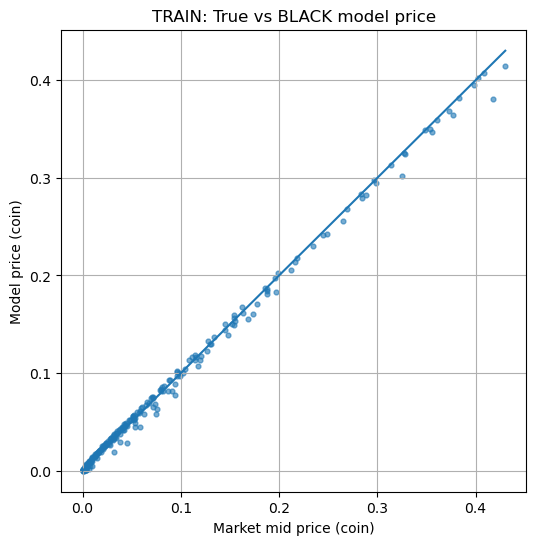

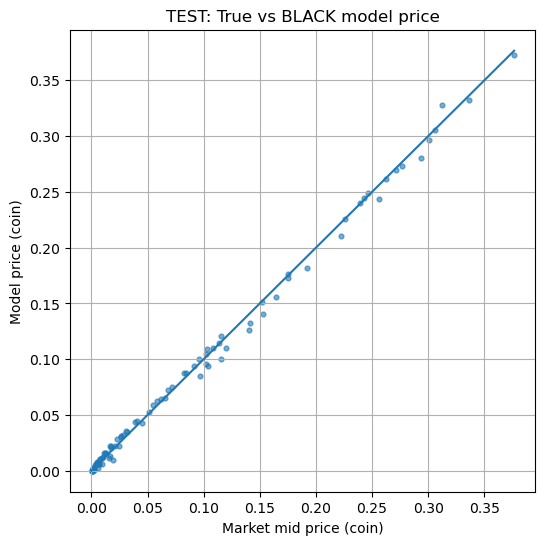

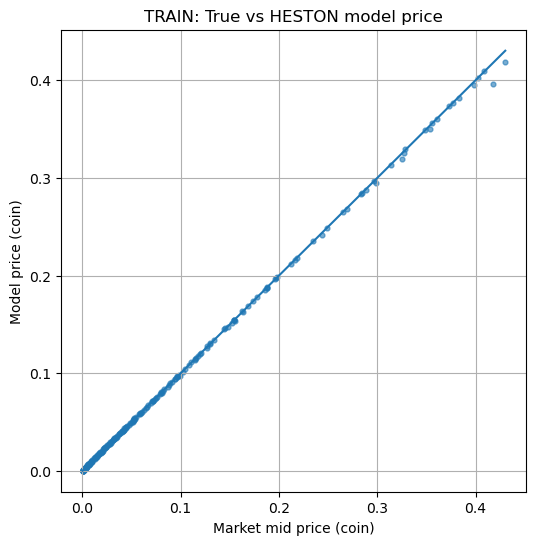

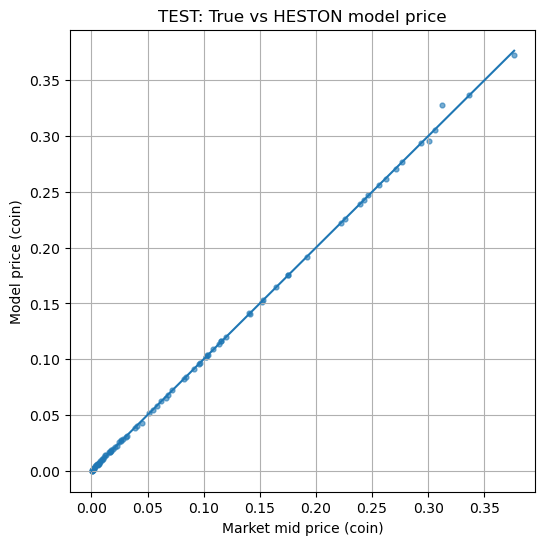

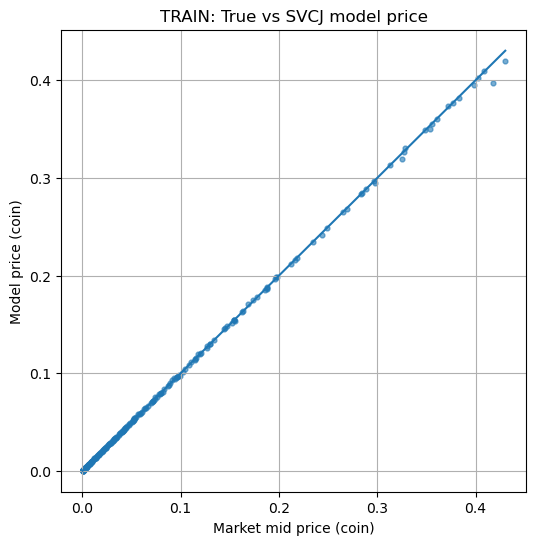

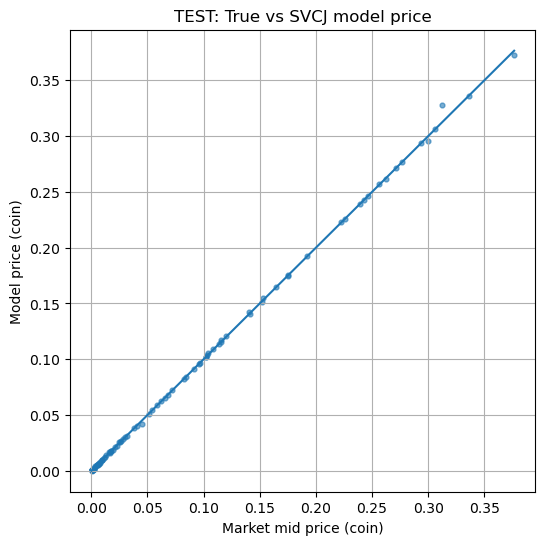

In [13]:
# --- Plot true vs model prices (coin units) ---
def plot_true_vs_model(df_in, col, title):
    y = df_in["mid_price_clean"].to_numpy()
    yhat = df_in[col].to_numpy()

    plt.figure(figsize=(6, 6))
    plt.scatter(y, yhat, s=12, alpha=0.6)
    lo = float(min(y.min(), yhat.min()))
    hi = float(max(y.max(), yhat.max()))
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("Market mid price (coin)")
    plt.ylabel("Model price (coin)")
    plt.title(title)
    plt.grid(True)
    plt.show()

for m in ["black", "heston", "svcj"]:
    plot_true_vs_model(train_p, f"model_price_{m}", f"TRAIN: True vs {m.upper()} model price")
    plot_true_vs_model(test_p,  f"model_price_{m}", f"TEST: True vs {m.upper()} model price")